# Exploring arbitrage opportunities

In this project, we analyze whether individual traders without access to low-latency systems, can still exploit arbitrage opportunities in cryptocurrency markets. Our focus is on two major exchanges: Bybit and HTX

In [801]:
import sqlite3
import sqlalchemy
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import websockets
import time
import json
import requests
import gzip
import nest_asyncio
import asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## 1. Upload data

Connect to SQLite database:

In [29]:
connection = sqlite3.connect("crypto.db")
cursor = connection.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS data(exchange TEXT, ts INTEGER, \
               bid_price REAL, bid_amount REAL, ask_price REAL, ask_amount REAL)")

connection.commit()

After analyzing multiple cryptocurrency pairs, I identified LTC/USDT to be the focus of this project, as this pair exhibits the most pronounced price discrepancies

In [58]:
nest_asyncio.apply()

market_data = {"HTX": None, "Bybit": None} ## store data here


async def get_htx():
    
    """
    Function to upload best bids/asks from HTX; more info on https://huobiapi.github.io/docs/spot/v1/en
    """
    
    uri = "wss://api-aws.huobi.pro/ws"
    while True: 
        try:
            async with websockets.connect(uri) as websocket:
                
                # Subscribe to HTX stream
                subscribe_msg = {"sub": "market.ltcusdt.bbo", "id": "htx_bbo"}
                await websocket.send(json.dumps(subscribe_msg))

                while True:
                    try:
                        # data from HTX needs to be decompressed  
                        compressed_data = await websocket.recv()
                        decompressed_data = gzip.decompress(compressed_data).decode('utf-8')
                        data = json.loads(decompressed_data)
                        
                        #print(f"HTX Raw Data: {data}") # debugging
                        
                        # Handle ping messages: 
                        if "ping" in data:
                            await websocket.send(json.dumps({"pong": data["ping"]}))
                            continue

                        # Process updates
                        if "tick" in data:
                            htx_tick = data["tick"]
                            htx_ts = htx_tick["quoteTime"]
                            htx_bid, htx_ask = htx_tick["bid"], htx_tick["ask"]
                            htx_bid_size, htx_ask_size = htx_tick["bidSize"], htx_tick["askSize"]

                            market_data["HTX"] = {'ts': htx_ts, "bid": htx_bid, "ask": htx_ask, 'bid_size': htx_bid_size, 'ask_size': htx_ask_size}
                            
                            # Upload the data to SQLite database
                            cursor.execute("INSERT INTO data (exchange, ts, bid_price, bid_amount, ask_price, ask_amount) VALUES (?, ?, ?, ?, ?, ?)", ('HTX', htx_ts, htx_bid, htx_bid_size, htx_ask, htx_ask_size))
                            connection.commit()
                            
                            """
                            # Print HTX prices
                            print("-" * 50)
                            print(f"HTX\n{pd.to_datetime(htx_ts, unit = 'ms')}")
                            print(f"Prices\nBid: {htx_bid:.2f} | Ask: {htx_ask:.2f}\nLiquidity\nBid: {htx_bid_size} | Ask: {htx_ask_size}")
                            print("-" * 50)
                            """
                
                    except websockets.exceptions.ConnectionClosedError as e:
                        print("HTX", data)    
                        break
                
                # it is a common occurrence for websockets to disconnect 
                print(f"Reconnecting.")
                await asyncio.sleep(1)
            
        except Exception as e:
            print(f"HTX Error: {e}")
            
        except KeyboardInterrupt:
            print("\n### Interrupted ###")
            
                

async def get_bybit():
    
    """
    Function to upload best bids/asks from Bybit. More info on https://bybit-exchange.github.io/docs/v5
    """

    uri = "wss://stream.bybit.com/v5/public/spot"
    
    while True:
        try:
            async with websockets.connect(uri) as websocket:
                
                # Subscribe to Bybit stream 
                subscribe_msg = {"op": "subscribe", "args": ["orderbook.1.LTCUSDT"]}
                await websocket.send(json.dumps(subscribe_msg))

                while True:
                    try:
                        # Receive data; unlike HTX, Bybit sends decompressed data
                        response = await websocket.recv()
                        data = json.loads(response)

                        # print(f"Bybit Raw Data: {data}")

                        if "data" in data:
                            bb_tick = data["data"]
                            bb_ts = data.get("ts")
                            
                            ### we will need this due to pecularity of Bybit data. For more info you can activate print functions for both raw data (above) and transormed data (below) 
                            
                            if bb_tick.get('a'):
                                if float(bb_tick["a"][0][1])!=0: bb_ask, bb_ask_size = float(bb_tick["a"][0][0]), float(bb_tick["a"][0][1])   
                                else: bb_ask, bb_ask_size = float(bb_tick["a"][1][0]), float(bb_tick["a"][1][1])

                            if bb_tick.get('b'):
                                if float(bb_tick["b"][0][1])!=0: bb_bid, bb_bid_size = float(bb_tick["b"][0][0]), float(bb_tick["b"][0][1])
                                else: bb_bid, bb_bid_size = float(bb_tick["b"][1][0]), float(bb_tick["b"][1][1])
                            
                            market_data["Bybit"] = {'ts': bb_ts, "bid": bb_bid, "ask": bb_ask, 'bid_size': bb_bid_size, 'ask_size': bb_ask_size}
                               
                            cursor.execute("INSERT INTO data (exchange, ts, bid_price, bid_amount, ask_price, ask_amount) VALUES (?, ?, ?, ?, ?, ?)", ('Bybit', bb_ts, bb_bid, bb_bid_size, bb_ask, bb_ask_size))
                            connection.commit()
                            
                            """
                            print("-" * 50)
                            formatted_ts = pd.to_datetime(bb_ts, unit = 'ms')
                            print(f"Bybit\n {formatted_ts}")
                            print(f"Prices\nBid: {bb_bid:.2f} | Ask: {bb_ask:.2f}\nLiquidity\nBid: {bb_bid_size} | Ask: {bb_ask_size}")
                            print("-" * 50)                            
                            """
                            
                    except websockets.exceptions.ConnectionClosedError as e:
                        print("Bybit", data)  
                        break
                
                print(f"Reconnecting.")
                await asyncio.sleep(1)
            
        except Exception as e:
            print(f"Bybit Error: {e}")
            
        except KeyboardInterrupt:
            print("\n### Interrupted ###")
            
            


async def main():
    """We use async function to get data from two exchanges simultaneously"""
    try: await asyncio.gather(get_htx(), get_bybit())
    except KeyboardInterrupt:
        print("\n### Interrupted ###")


try:
    asyncio.run(main())
except KeyboardInterrupt:
    print("\n### Interrupted ###")


### Interrupted ###

### Interrupted ###


## 2. Analyze data

In [121]:
engine = sqlalchemy.create_engine("sqlite:///crypto.db")
df = pd.read_sql("data", engine)
df

,exchange,ts,bid_price,bid_amount,ask_price,ask_amount
0,Bybit,1739894192200,124.90,4.95000,124.92,8.82803
1,Bybit,1739894192320,124.90,4.95000,124.92,4.95000
2,Bybit,1739894192330,124.90,6.01479,124.93,4.95000
3,Bybit,1739894192340,124.91,5.26058,124.93,4.95000
4,Bybit,1739894192360,124.91,5.26058,124.94,0.89042
...,...,...,...,...,...,...
572353,HTX,1739902229312,125.97,4.90750,125.98,2.56110
572354,HTX,1739902229343,125.97,4.90750,125.98,5.26110
572355,HTX,1739902229349,125.97,2.20750,125.98,5.26110
572356,HTX,1739902229411,125.97,4.90750,125.98,5.26110


In [307]:
# merge the data from 2 exchanges
HTX = df.loc[(df.exchange == "HTX"), ['ts', 'bid_price', 'bid_amount', 'ask_price', 'ask_amount']]
Bybit = df.loc[(df.exchange == "Bybit"), ['ts', 'bid_price', 'bid_amount', 'ask_price', 'ask_amount']]
df_ = pd.merge(HTX, Bybit, on = 'ts', how = "outer", suffixes=("_HTX", "_Bybit")).sort_values(by = 'ts')


#add info on the exact time when the data was obtained
df_['tsHTX'] = df_['ts'].where(df_['bid_price_HTX'].notna(), np.nan)
df_['tsBB'] = df_['ts'].where(df_['bid_price_Bybit'].notna(), np.nan)
df_.ffill(inplace = True)
df_.dropna(inplace = True)
df_['timedelta'] = df_.tsHTX - df_.tsBB


df_.tsHTX, df_.tsBB = pd.to_datetime(df_.tsHTX, unit = "ms"), pd.to_datetime(df_.tsBB, unit = "ms")
df_.reset_index(inplace = True, drop = True)
df_

,ts,bid_price_HTX,bid_amount_HTX,ask_price_HTX,ask_amount_HTX,bid_price_Bybit,bid_amount_Bybit,ask_price_Bybit,ask_amount_Bybit,tsHTX,tsBB,timedelta
0,1739894192984,124.93,1.8164,124.96,5.4000,124.92,5.92958,124.94,4.95000,2025-02-18 15:56:32.984000000,2025-02-18 15:56:32.849999872,134.0
1,1739894192990,124.91,5.4000,124.96,5.4000,124.92,5.92958,124.94,4.95000,2025-02-18 15:56:32.990000128,2025-02-18 15:56:32.849999872,140.0
2,1739894193000,124.91,5.4000,124.96,5.4000,124.92,5.92958,124.95,14.63976,2025-02-18 15:56:32.990000128,2025-02-18 15:56:33.000000000,-10.0
3,1739894193010,124.91,5.4000,124.96,5.4000,124.93,3.01779,124.95,14.57972,2025-02-18 15:56:32.990000128,2025-02-18 15:56:33.009999872,-20.0
4,1739894193067,124.91,5.4000,124.96,2.7000,124.93,3.01779,124.95,14.57972,2025-02-18 15:56:33.067000064,2025-02-18 15:56:33.009999872,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
561102,1739902229312,125.97,4.9075,125.98,2.5611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.312000000,2025-02-18 18:10:18.929999872,10382.0
561103,1739902229343,125.97,4.9075,125.98,5.2611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.343000064,2025-02-18 18:10:18.929999872,10413.0
561104,1739902229349,125.97,2.2075,125.98,5.2611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.348999936,2025-02-18 18:10:18.929999872,10419.0
561105,1739902229411,125.97,4.9075,125.98,5.2611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.411000064,2025-02-18 18:10:18.929999872,10481.0


Define 2 strategies: bBsH (buy at Bibyt, sell at HTX) and bHsB (buy at HTX, sell at Bibyt). Next, calculate possible returns (ex-fees): for this we compare bid and ask offers at 2 exchanges; we keep in mind that ask price is always higher than bid price

In [310]:
df_['bBsH, %'] = (df_['bid_price_HTX'] / df_['ask_price_Bybit'] - 1).where((df_['bid_price_HTX'] / df_['ask_price_Bybit'])>1, 0)*100
df_['bBsH, liq'] = np.minimum(
    df_["bid_amount_HTX"] * df_['bid_price_HTX'],
    df_["ask_amount_Bybit"] * df_['ask_price_Bybit'])

#we add minus sign to check possibility of reducing fees: indeed, we would not need to transfer coins from one exchange to another if we can alternate shorts and longs on each exchange
df_['bHsB, %'] = -(df_['bid_price_Bybit'] / df_['ask_price_HTX'] - 1).where((df_['bid_price_Bybit'] / df_['ask_price_HTX'])>1, 0)*100  

#Also we should consider available liquidity
df_['bHsB, liq'] = -np.minimum(
    df_["bid_amount_Bybit"] * df_['bid_price_Bybit'],
    df_["ask_amount_HTX"] * df_['ask_price_HTX'])

df_

,ts,bid_price_HTX,bid_amount_HTX,ask_price_HTX,ask_amount_HTX,bid_price_Bybit,bid_amount_Bybit,ask_price_Bybit,ask_amount_Bybit,tsHTX,tsBB,timedelta,"bBsH, %","bBsH, liq","bHsB, %","bHsB, liq"
0,1739894192984,124.93,1.8164,124.96,5.4000,124.92,5.92958,124.94,4.95000,2025-02-18 15:56:32.984000000,2025-02-18 15:56:32.849999872,134.0,0.0,226.922852,-0.0,-674.784000
1,1739894192990,124.91,5.4000,124.96,5.4000,124.92,5.92958,124.94,4.95000,2025-02-18 15:56:32.990000128,2025-02-18 15:56:32.849999872,140.0,0.0,618.453000,-0.0,-674.784000
2,1739894193000,124.91,5.4000,124.96,5.4000,124.92,5.92958,124.95,14.63976,2025-02-18 15:56:32.990000128,2025-02-18 15:56:33.000000000,-10.0,0.0,674.514000,-0.0,-674.784000
3,1739894193010,124.91,5.4000,124.96,5.4000,124.93,3.01779,124.95,14.57972,2025-02-18 15:56:32.990000128,2025-02-18 15:56:33.009999872,-20.0,0.0,674.514000,-0.0,-377.012505
4,1739894193067,124.91,5.4000,124.96,2.7000,124.93,3.01779,124.95,14.57972,2025-02-18 15:56:33.067000064,2025-02-18 15:56:33.009999872,57.0,0.0,674.514000,-0.0,-337.392000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561102,1739902229312,125.97,4.9075,125.98,2.5611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.312000000,2025-02-18 18:10:18.929999872,10382.0,0.0,6.975513,-0.0,-322.647378
561103,1739902229343,125.97,4.9075,125.98,5.2611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.343000064,2025-02-18 18:10:18.929999872,10413.0,0.0,6.975513,-0.0,-623.452500
561104,1739902229349,125.97,2.2075,125.98,5.2611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.348999936,2025-02-18 18:10:18.929999872,10419.0,0.0,6.975513,-0.0,-623.452500
561105,1739902229411,125.97,4.9075,125.98,5.2611,125.95,4.95000,125.98,0.05537,2025-02-18 18:10:29.411000064,2025-02-18 18:10:18.929999872,10481.0,0.0,6.975513,-0.0,-623.452500


Now plot out findings

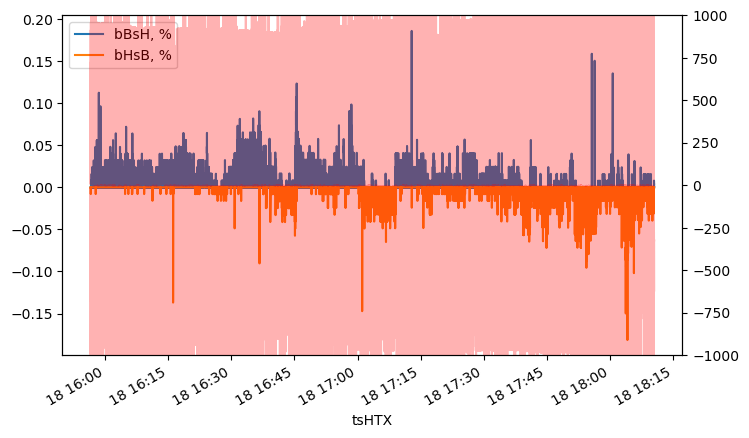

In [209]:
ax = df_.plot(x='tsHTX', y=['bBsH, %', 'bHsB, %'], figsize=(8,5))

# Create secondary axis to check available liquidity
ax_td = ax.twinx()
ax_td.plot(df_['tsHTX'], df_[['bBsH, liq', 'bHsB, liq']], color='red', alpha=0.3)
ax_td.set_ylim(bottom = -1000, top=1000)


ax.legend(['bBsH, %', 'bHsB, %'], loc='upper left')

plt.show()

In the plot above, we observe that price discrepancies between Bybit and HTX indeed exist. Additionally, the available liquidity at these price levels appears sufficient, suggesting that these opportunities can be realistically exploited. However, we should also bear in mind the time difference between price updates across exchanges: execution feasibility depends on synchronization between Bybit and HTX. Even a minor delay in price updates usually lead to increased risks.

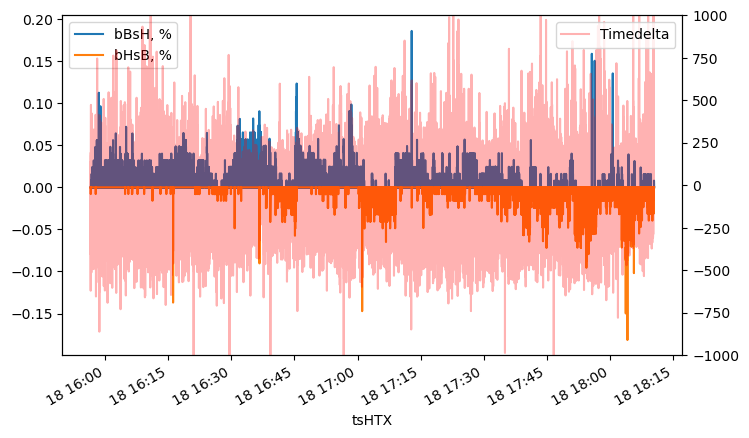

In [211]:
ax = df_.plot(x='tsHTX', y=['bBsH, %', 'bHsB, %'], figsize=(8,5))

# Create secondary axis
ax_td = ax.twinx()
ax_td.plot(df_['tsHTX'], df_['timedelta'], color='red', alpha=0.3, label='Timedelta')
ax_td.set_ylim(bottom = -1000, top= 1000)

# Add legends separately for both axes
ax.legend(['bBsH, %', 'bHsB, %'], loc='upper left')
ax_td.legend(['Timedelta'], loc='upper right')

plt.show()

We can see that the time difference can be up to half a second in most cases. This is too much, but may be not too critical. Now we have to dig deeper to see, how persistent these opportunities are 

In [863]:
df_["profit, %"] = np.maximum(df_["bBsH, %"], df_["bHsB, %"])

df_.nlargest(20, "profit, %") #identify 20 "cushiest" opportunities to check how persistent they are

,ts,bid_price_HTX,bid_amount_HTX,ask_price_HTX,ask_amount_HTX,bid_price_Bybit,bid_amount_Bybit,ask_price_Bybit,ask_amount_Bybit,tsHTX,tsBB,timedelta,"bBsH, %","bBsH, liq","bHsB, %","bHsB, liq","profit, %"
327993,1739898772291,123.95,20.4653,123.96,2.8831,123.71,0.13608,123.72,0.10901,2025-02-18 17:12:52.291000064,2025-02-18 17:12:52.289999872,1.0,0.185904,13.486717,-0.0,-16.834457,0.185904
496211,1739901340427,126.18,23.3777,126.25,0.5077,125.96,0.05537,125.98,5.79180,2025-02-18 17:55:40.427000064,2025-02-18 17:55:40.340000000,87.0,0.158755,729.650964,-0.0,-6.974405,0.158755
496214,1739901340429,126.18,23.3777,126.31,2.0887,125.96,0.05537,125.98,5.79180,2025-02-18 17:55:40.428999936,2025-02-18 17:55:40.340000000,89.0,0.158755,729.650964,-0.0,-6.974405,0.158755
499064,1739901380816,126.50,55.9690,126.51,0.2847,126.28,2.65952,126.31,3.74527,2025-02-18 17:56:20.816000000,2025-02-18 17:56:20.809999872,6.0,0.150424,473.065054,-0.0,-36.017397,0.150424
499065,1739901380820,126.50,55.9690,126.53,2.7000,126.28,5.46279,126.31,3.74527,2025-02-18 17:56:20.820000000,2025-02-18 17:56:20.820000000,0.0,0.150424,473.065054,-0.0,-341.631000,0.150424
499066,1739901380823,126.50,54.6013,126.53,2.7000,126.28,5.46279,126.31,3.74527,2025-02-18 17:56:20.823000064,2025-02-18 17:56:20.820000000,3.0,0.150424,473.065054,-0.0,-341.631000,0.150424
499067,1739901380823,126.50,54.0595,126.53,2.7000,126.28,5.46279,126.31,3.74527,2025-02-18 17:56:20.823000064,2025-02-18 17:56:20.820000000,3.0,0.150424,473.065054,-0.0,-341.631000,0.150424
499068,1739901380823,126.50,21.5457,126.53,2.7000,126.28,5.46279,126.31,3.74527,2025-02-18 17:56:20.823000064,2025-02-18 17:56:20.820000000,3.0,0.150424,473.065054,-0.0,-341.631000,0.150424
513000,1739901639470,125.69,0.5150,125.70,8.1490,125.51,94.26169,125.52,1785.69871,2025-02-18 18:00:39.388999936,2025-02-18 18:00:39.470000128,-81.0,0.135437,64.730350,-0.0,-1024.329300,0.135437
210631,1739897132470,121.72,58.1979,121.73,174.8913,121.55,27.97848,121.57,0.84180,2025-02-18 16:45:32.465999872,2025-02-18 16:45:32.470000128,-4.0,0.123386,102.337626,-0.0,-3400.784244,0.123386


In [314]:
pos = df_.nlargest(1, "profit, %").index[0]
df_.iloc[pos-5:pos+10]

,ts,bid_price_HTX,bid_amount_HTX,ask_price_HTX,ask_amount_HTX,bid_price_Bybit,bid_amount_Bybit,ask_price_Bybit,ask_amount_Bybit,tsHTX,tsBB,timedelta,"bBsH, %","bBsH, liq","bHsB, %","bHsB, liq","profit, %"
327988,1739898772285,123.72,2.7000,123.89,2.2864,123.71,0.53530,123.72,0.10901,2025-02-18 17:12:52.284999936,2025-02-18 17:12:52.190000128,95.0,0.000000,13.486717,-0.0,-66.221963,-0.000000
327989,1739898772285,123.72,2.7000,123.89,5.0414,123.71,0.53530,123.72,0.10901,2025-02-18 17:12:52.284999936,2025-02-18 17:12:52.190000128,95.0,0.000000,13.486717,-0.0,-66.221963,-0.000000
327990,1739898772287,123.72,2.7000,123.89,2.7550,123.71,0.53530,123.72,0.10901,2025-02-18 17:12:52.287000064,2025-02-18 17:12:52.190000128,97.0,0.000000,13.486717,-0.0,-66.221963,-0.000000
327991,1739898772289,123.72,5.4550,123.89,2.7550,123.71,0.53530,123.72,0.10901,2025-02-18 17:12:52.288999936,2025-02-18 17:12:52.190000128,99.0,0.000000,13.486717,-0.0,-66.221963,-0.000000
327992,1739898772290,123.72,5.4550,123.89,2.7550,123.71,0.13608,123.72,0.10901,2025-02-18 17:12:52.288999936,2025-02-18 17:12:52.289999872,-1.0,0.000000,13.486717,-0.0,-16.834457,-0.000000
327993,1739898772291,123.95,20.4653,123.96,2.8831,123.71,0.13608,123.72,0.10901,2025-02-18 17:12:52.291000064,2025-02-18 17:12:52.289999872,1.0,0.185904,13.486717,-0.0,-16.834457,0.185904
327994,1739898772300,123.95,20.4653,123.96,5.5831,123.79,1.32397,123.89,5.62970,2025-02-18 17:12:52.300000000,2025-02-18 17:12:52.300000000,0.0,0.048430,697.463533,-0.0,-163.894246,0.048430
327995,1739898772300,123.73,18.9450,123.96,5.5831,123.79,1.32397,123.89,5.62970,2025-02-18 17:12:52.300000000,2025-02-18 17:12:52.300000000,0.0,0.000000,697.463533,-0.0,-163.894246,-0.000000
327996,1739898772305,123.73,18.9450,123.96,8.3381,123.79,1.32397,123.89,5.62970,2025-02-18 17:12:52.304999936,2025-02-18 17:12:52.300000000,5.0,0.000000,697.463533,-0.0,-163.894246,-0.000000
327997,1739898772306,123.74,2.7000,123.96,8.3381,123.79,1.32397,123.89,5.62970,2025-02-18 17:12:52.305999872,2025-02-18 17:12:52.300000000,6.0,0.000000,334.098000,-0.0,-163.894246,-0.000000


In [316]:
i = 15
pos = df_.nlargest(i, "profit, %").index[-1]
df_.iloc[pos-5:pos+50]

,ts,bid_price_HTX,bid_amount_HTX,ask_price_HTX,ask_amount_HTX,bid_price_Bybit,bid_amount_Bybit,ask_price_Bybit,ask_amount_Bybit,tsHTX,tsBB,timedelta,"bBsH, %","bBsH, liq","bHsB, %","bHsB, liq","profit, %"
209776,1739897123266,121.72,935.6287,121.73,25.6027,121.59,5.19261,121.60,3.45070,2025-02-18 16:45:23.265999872,2025-02-18 16:45:23.260000000,6.0,0.098684,419.605120,-0.0,-631.369450,0.098684
209777,1739897123270,121.72,935.6287,121.73,25.6027,121.58,14.11686,121.60,3.45070,2025-02-18 16:45:23.265999872,2025-02-18 16:45:23.270000128,-4.0,0.098684,419.605120,-0.0,-1716.327839,0.098684
209778,1739897123272,121.72,935.3352,121.73,25.6027,121.58,14.11686,121.60,3.45070,2025-02-18 16:45:23.272000000,2025-02-18 16:45:23.270000128,2.0,0.098684,419.605120,-0.0,-1716.327839,0.098684
209779,1739897123274,121.72,925.4332,121.73,25.6027,121.58,14.11686,121.60,3.45070,2025-02-18 16:45:23.273999872,2025-02-18 16:45:23.270000128,4.0,0.098684,419.605120,-0.0,-1716.327839,0.098684
209780,1739897123280,121.72,863.8164,121.73,25.6027,121.58,11.68705,121.59,0.84180,2025-02-18 16:45:23.280000000,2025-02-18 16:45:23.280000000,0.0,0.106917,102.354462,-0.0,-1420.911539,0.106917
209781,1739897123284,121.72,862.7765,121.73,25.6027,121.58,11.68705,121.59,0.84180,2025-02-18 16:45:23.284000000,2025-02-18 16:45:23.280000000,4.0,0.106917,102.354462,-0.0,-1420.911539,0.106917
209782,1739897123285,121.72,862.6266,121.73,25.6027,121.58,11.68705,121.59,0.84180,2025-02-18 16:45:23.284999936,2025-02-18 16:45:23.280000000,5.0,0.106917,102.354462,-0.0,-1420.911539,0.106917
209783,1739897123290,121.72,801.0050,121.73,25.6027,121.57,3.78069,121.59,0.84180,2025-02-18 16:45:23.289999872,2025-02-18 16:45:23.289999872,0.0,0.106917,102.354462,-0.0,-459.618483,0.106917
209784,1739897123294,121.72,800.8651,121.73,24.9507,121.57,3.78069,121.59,0.84180,2025-02-18 16:45:23.294000128,2025-02-18 16:45:23.289999872,4.0,0.106917,102.354462,-0.0,-459.618483,0.106917
209785,1739897123294,121.72,800.8651,121.73,25.6027,121.57,3.78069,121.59,0.84180,2025-02-18 16:45:23.294000128,2025-02-18 16:45:23.289999872,4.0,0.106917,102.354462,-0.0,-459.618483,0.106917


So it is obvious that all the cushy opportunities are exploited well within a second. What about less lucrative trades?

In [293]:
dict(sorted(({_: df_.loc[round(df_["profit, %"],2) == _, "profit, %"].shape[0] for _ in set(round(df_["profit, %"], 2).values)}).items()))

{-0.0: 491142,
 0.01: 36757,
 0.02: 26274,
 0.03: 3643,
 0.04: 1753,
 0.05: 695,
 0.06: 295,
 0.07: 337,
 0.08: 70,
 0.09: 46,
 0.1: 40,
 0.11: 44,
 0.12: 2,
 0.14: 1,
 0.15: 5,
 0.16: 2,
 0.19: 1}

Good news! There are still many opportunities we can target. We aim to focus on a certain margin range, namely, on avoiding low-margin and high-margin trades (as they vanish too quickly due to latency constraints). Let's see what inference we can make about the profit range of 0.03-0.06%

In [626]:
df_n = df_[['ts', 'timedelta', 'profit, %']].copy()
df_n["timedelta"] = abs(df_n["timedelta"])


df_n["arbitrage_start"] = (df_n["profit, %"].between(0.03, 0.07)) & (df_n["profit, %"].shift(1) < 0.03) # Identify the start of an arbitrage opportunity
df_n["arbitrage_id"] = df_n["arbitrage_start"].cumsum() # Create an arbitrage ID for grouping 
df_n["active_arbitrage"] = (df_n["profit, %"] >= 0.03) # Track arbitrage until `profit, %` drops below 0.03
df_n["arbitrage_id"] = df_n["arbitrage_id"].where(df_n["active_arbitrage"]) # Assign arbitrage ID only if it's part of an opportunity

df_n["length"] = df_n.ts.shift(-1) - df_n.ts 

arbitrage_durations = df_n.groupby("arbitrage_id")["length"].sum()
arbitrage_durations = arbitrage_durations.dropna()

df_n

,ts,timedelta,"profit, %",arbitrage_start,arbitrage_id,active_arbitrage,length
0,1739894192984,134.0,-0.0,False,NaN,False,6.0
1,1739894192990,140.0,-0.0,False,NaN,False,10.0
2,1739894193000,10.0,-0.0,False,NaN,False,10.0
3,1739894193010,20.0,-0.0,False,NaN,False,57.0
4,1739894193067,57.0,-0.0,False,NaN,False,22.0
...,...,...,...,...,...,...,...
561102,1739902229312,10382.0,-0.0,False,NaN,False,31.0
561103,1739902229343,10413.0,-0.0,False,NaN,False,6.0
561104,1739902229349,10419.0,-0.0,False,NaN,False,62.0
561105,1739902229411,10481.0,-0.0,False,NaN,False,215.0


Verify that everything is working correctly:

In [682]:
pos = df_n.nlargest(100, "profit, %").index[-1]
df_n.iloc[pos-114:pos-45]

,ts,timedelta,"profit, %",arbitrage_start,arbitrage_id,active_arbitrage,length
209608,1739897120940,92.0,0.024653,False,NaN,False,11.0
209609,1739897120951,103.0,0.032873,True,1041.0,True,4.0
209610,1739897120955,4.0,0.032873,False,1041.0,True,8.0
209611,1739897120963,8.0,0.032873,False,1041.0,True,3.0
209612,1739897120966,3.0,0.032873,False,1041.0,True,9.0
...,...,...,...,...,...,...,...
209672,1739897121710,105.0,0.041095,False,1041.0,True,17.0
209673,1739897121727,17.0,0.041095,False,1041.0,True,30.0
209674,1739897121757,47.0,0.041095,False,1041.0,True,33.0
209675,1739897121790,33.0,0.041095,False,1041.0,True,50.0


In [660]:
i = 10
arbitrage_durations.loc[i] == sum(df_n.loc[df_n.arbitrage_id == i, "length"])

True

In [844]:
print(f'Total number of observed opportunities: {len(arbitrage_durations)} \
        \nTotal duration of observation: {str(datetime.timedelta(milliseconds = int(df_.ts.iloc[-1] - df_.ts.iloc[0])))} \
        \nAverage length of arbitrage opportunity: {arbitrage_durations.mean():.0f} ms')

Total number of observed opportunities: 1364         
Total duration of observation: 2:13:56.642000         
Average length of arbitrage opportunity: 71 ms


In [797]:
arbitrage_durations.sort_values(ascending = False).iloc[:50]

arbitrage_id
1151.0    6250.0
552.0     2590.0
1160.0    1811.0
1041.0    1539.0
1293.0    1260.0
1144.0    1240.0
303.0     1240.0
1042.0    1220.0
435.0     1190.0
1209.0    1170.0
218.0      905.0
360.0      860.0
1016.0     850.0
183.0      847.0
240.0      800.0
730.0      760.0
843.0      753.0
56.0       700.0
563.0      690.0
1086.0     680.0
908.0      675.0
10.0       650.0
5.0        643.0
70.0       632.0
425.0      623.0
376.0      622.0
593.0      620.0
1139.0     610.0
1023.0     553.0
75.0       520.0
1092.0     520.0
42.0       488.0
596.0      470.0
579.0      470.0
782.0      468.0
1179.0     467.0
1064.0     461.0
374.0      460.0
1206.0     450.0
1271.0     448.0
844.0      442.0
214.0      440.0
663.0      430.0
1055.0     430.0
599.0      421.0
1314.0     420.0
195.0      413.0
1200.0     410.0
1202.0     409.0
185.0      409.0
Name: length, dtype: float64

It is obvious that there are some outliers on both sides. Let's get rid of them and also of unfeasible opportunities:

In [836]:
feasible_arbitrage_durations = arbitrage_durations[arbitrage_durations.between(50, 1000)]

In [846]:
print(f'Total number of observed opportunities: {len(feasible_arbitrage_durations)} \
        \nAverage length of arbitrage opportunity: {feasible_arbitrage_durations.mean():.0f} ms')

Total number of observed opportunities: 328         
Average length of arbitrage opportunity: 196 ms


Let's plot the distribution of durations:

D:\Python\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Python\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


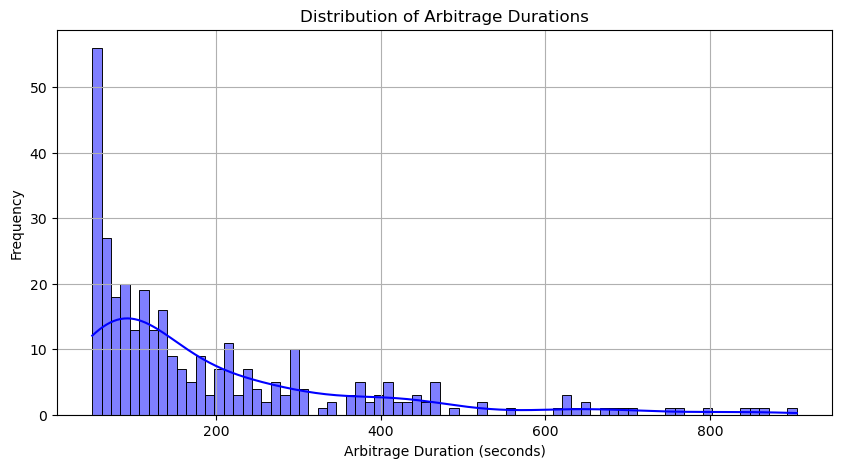

In [838]:
plt.figure(figsize=(10, 5))
sns.histplot(feasible_arbitrage_durations, bins=75, kde=True, color='blue')

plt.xlabel("Arbitrage Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Arbitrage Durations")
plt.grid(True)
plt.show()

The distribution of arbitrage opportunity durations is heavily right-skewed. This is some unpleasant news given that executing a trade via API takes approximately 500 ms (however, execution speed can be improved using solutions like AWS). We still managed to identify over 300 marginal opportunities within two hours of observation. The next challenge is to develop a predictive model to assess whether an arbitrage opportunity will persist long enough to be executed. Additionally, we need to design a risk management strategy for scenarios where a trade is executed on one exchange, but the corresponding counter-trade fails on the other.